In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import transformers
%matplotlib inline

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# convert str to datatime
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
def loadMat(matfile):
    data = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data.append(d1)

    return data


# get capacity data
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]


# get the charge data of a battery
def getBatteryValues(Battery, Type='charge'):
    data=[]
    for Bat in Battery:
        if Bat['type'] == Type:
            data.append(Bat['data'])
    return data

In [ ]:
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = 'datasets/NASA/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data = loadMat(path)
    Battery[name] = getBatteryCapacity(data)

Load Dataset B0005.mat ...
Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


In [ ]:
def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)


def split_dataset(data_sequence, train_ratio=0.0, capacity_threshold=0.0):
    if capacity_threshold > 0:
        max_capacity = max(data_sequence)
        capacity = max_capacity * capacity_threshold
        point = [i for i in range(len(data_sequence)) if data_sequence[i] < capacity]
    else:
        point = int(train_ratio + 1)
        if 0 < train_ratio <= 1:
            point = int(len(data_sequence) * train_ratio)
    train_data, test_data = data_sequence[:point], data_sequence[point:]
    return train_data, test_data


# leave-one-out evaluation: one battery is sampled randomly; the remainder are used for training.
def get_train_test(data_dict, name, window_size=8):
    data_sequence=data_dict[name][1]
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v[1], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re


def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    mae = mean_absolute_error(y_test,y_predict)
    return rmse , mae


def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_size=16, hidden_dim=8, noise_level=0.01):
        super(Autoencoder, self).__init__()
        self.input_size, self.hidden_dim, self.noise_level = input_size, hidden_dim, noise_level
        self.fc1 = nn.Linear(self.input_size, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.input_size)

    def encoder(self, x):
        x = self.fc1(x)
        h1 = F.relu(x)
        return h1

    def mask(self, x):
        corrupted_x = x + self.noise_level * torch.randn_like(x)
        return corrupted_x

    def decoder(self, x):
        h2 = self.fc2(x)
        return h2

    def forward(self, x):
        out = self.mask(x)
        encode = self.encoder(out)
        decode = self.decoder(encode)
        return encode, decode


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.0, max_len=16):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :].squeeze(1)
        return x


class Net(nn.Module):
    def __init__(self, feature_size=16, hidden_dim=32, num_layers=1, nhead=8, dropout=0.0, noise_level=0.01):
        super(Net, self).__init__()
        self.auto_hidden = int(feature_size/2)
        input_size = self.auto_hidden
        self.pos = PositionalEncoding(d_model=input_size, max_len=input_size)
        encoder_layers = nn.TransformerEncoderLayer(d_model=input_size, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout)
        self.cell = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.linear = nn.Linear(input_size, 1)
        self.autoencoder = Autoencoder(input_size=feature_size, hidden_dim=self.auto_hidden, noise_level=noise_level)

    def forward(self, x):
        batch_size, feature_num, feature_size  = x.shape
        encode, decode = self.autoencoder(x.reshape(batch_size, -1))# batch_size*seq_len
        out = encode.reshape(batch_size, -1, self.auto_hidden)
        out = self.pos(out)
        out = out.reshape(1, batch_size, -1) # (1, batch_size, feature_size)
        out = self.cell(out)
        out = out.reshape(batch_size, -1) # (batch_size, hidden_dim)
        out = self.linear(out)            # out shape: (batch_size, 1)

        return out, decode

In [ ]:
def train(lr=0.01, feature_size=8, hidden_dim=32, num_layers=1, nhead=8, weight_decay=0.0, EPOCH=1000, seed=0,
         alpha=0.0, noise_level=0.0, dropout=0.0, metric='re', is_load_weights=True):
    score_list, result_list = [], []
    setup_seed(seed)
    for i in range(4):
        name = Battery_list[i]
        window_size = feature_size
        train_x, train_y, train_data, test_data = get_train_test(Battery, name, window_size)
        train_size = len(train_x)
        # print('sample size: {}'.format(train_size))

        model = Net(feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, nhead=nhead, dropout=dropout,
                    noise_level=noise_level)
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()

        '''
        # save ramdom data for repetition
        if torch.__version__.split('+')[0] >= '1.6.0':
            torch.save(model.state_dict(), 'model_NASA'+str(seed)+'.pth')
        else:
            torch.save(model.state_dict(), 'model_NASA.pth', _use_new_zipfile_serialization=False)
        '''
        # load the random data generated by my device
        if is_load_weights:
            if torch.__version__.split('+')[0] >= '1.6.0':
                model.load_state_dict(torch.load('initial_weights/model_NASA.pth'))
            else:
                model.load_state_dict(torch.load('initial_weights/model_NASA_1.5.0.pth'))

        test_x = train_data.copy()
        loss_list, y_ = [0], []
        rmse, re , mae= 1, 1 , 1
        score_, score = [1],[1]
        for epoch in range(EPOCH):
            X = np.reshape(train_x/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32) # (batch_size, seq_len, input_size)
            y = np.reshape(train_y[:,-1]/Rated_Capacity,(-1,1)).astype(np.float32)          # (batch_size, 1)

            X, y = torch.from_numpy(X).to(device), torch.from_numpy(y).to(device)
            output, decode = model(X)
            output = output.reshape(-1, 1)
            loss = criterion(output, y) + alpha * criterion(decode, X.reshape(-1, feature_size))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (epoch + 1)%10 == 0:
                test_x = train_data.copy()
                point_list = []
                while (len(test_x) - len(train_data)) < len(test_data):
                    x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x).to(device)
                    pred, _ = model(x)
                    next_point = pred.data.cpu().numpy()[0,0] * Rated_Capacity
                    test_x.append(next_point)      # The test values are added to the original sequence to continue to predict the next point
                    point_list.append(next_point)
                y_.append(point_list)

                loss_list.append(loss)
                rmse , mae = evaluation(y_test=test_data, y_predict=y_[-1])
                re = relative_error(y_test=test_data, y_predict=y_[-1], threshold=Rated_Capacity*0.7)
                #print('epoch:{:<2d} | loss:{:<6.4f} | RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, rmse, re))
            if metric == 're':
                score = [re]
            elif metric == 'rmse':

                score = [rmse]
            elif metric == 'mae':
                score = [mae]
            else:
                score = [re, rmse,mae]
            if (loss < 1e-3) and (score_[0] < score[0]):
                break
            score_ = score.copy()

        score_list.append(score_)
        result_list.append(y_[-1])
    return score_list, result_list

In [ ]:
Rated_Capacity = 2.0
window_size = 16
feature_size = window_size
dropout = 0.0
EPOCH = 2000
nhead = 8
is_load_weights = False

weight_decay = 0.0
alphas = [1e-5, 1e-4]
metrics = ['re', 'rmse', 'mae']
noise_levels = [0.001, 0.01, 0.05]

states = {metric: {} for metric in metrics}

for noise_level in noise_levels:
    for lr in [1e-3, 1e-2]:
        for num_layers in [1, 2]:
            for hidden_dim in [16, 32]:
                for alpha in alphas:
                    show_str = 'lr={}, num_layers={}, hidden_dim={}, alpha={}, noise_level={}'.format(
                        lr, num_layers, hidden_dim, alpha, noise_level)
                    print(show_str)

                    metric_scores = {metric: [] for metric in metrics}
                    for seed in range(5):
                        print('seed:{}'.format(seed))
                        score_list, _ = train(lr=lr, feature_size=feature_size, hidden_dim=hidden_dim,
                                              num_layers=num_layers, nhead=nhead,
                                              weight_decay=weight_decay, EPOCH=EPOCH, seed=seed, dropout=dropout,
                                              alpha=alpha,
                                              noise_level=noise_level, metric='all', is_load_weights=is_load_weights)
                        print(np.array(score_list))

                        for i, metric in enumerate(metrics):
                            metric_value = np.mean(np.array(score_list)[:, i])  # Calculate mean for each metric
                            print(metric + ': {:<6.4f}'.format(metric_value))
                            metric_scores[metric].append(metric_value)  # Append metric value to the list

                        print('------------------------------------------------------------------')


                    for metric in metrics:
                        metric_mean = np.mean(metric_scores[metric])
                        print(metric + ' mean: {:<6.4f}'.format(metric_mean))
                        states[metric][show_str] = metric_mean  # Store the mean score for the current metric

                    print('===================================================================')

# Find the optimal parameters for each metric
optimal_params = {}
for metric in metrics:
    optimal_params[metric] = min(states[metric], key=states[metric].get)

for metric, params in optimal_params.items():
    print(f'Optimal parameters for {metric}: {params}, result: {states[metric][params]}')


lr=0.001, num_layers=1, hidden_dim=16, alpha=1e-05, noise_level=0.001
seed:0
[[0.09433962 0.04822512 0.03984446]
 [1.         0.17328855 0.15078223]
 [0.03311258 0.05941379 0.04208135]
 [0.35897436 0.06122169 0.05272993]]
re: 0.3716
rmse: 0.0855
mae: 0.0714
------------------------------------------------------------------
seed:1
[[0.24528302 0.07198654 0.06394222]
 [0.62222222 0.14769006 0.13174398]
 [0.25165563 0.13756249 0.12725992]
 [1.         0.07761187 0.06836686]]
re: 0.5298
rmse: 0.1087
mae: 0.0978
------------------------------------------------------------------
seed:2
[[0.37735849 0.08446911 0.07656858]
 [0.64444444 0.15173764 0.13499   ]
 [0.22516556 0.13326737 0.12301236]
 [0.43589744 0.07604897 0.0670919 ]]
re: 0.4207
rmse: 0.1114
mae: 0.1004
------------------------------------------------------------------
seed:3
[[0.00943396 0.06936644 0.05515221]
 [0.61111111 0.14119046 0.1256744 ]
 [0.16556291 0.14120995 0.1270188 ]
 [0.29487179 0.0488817  0.04089878]]
re: 0.2702
rm

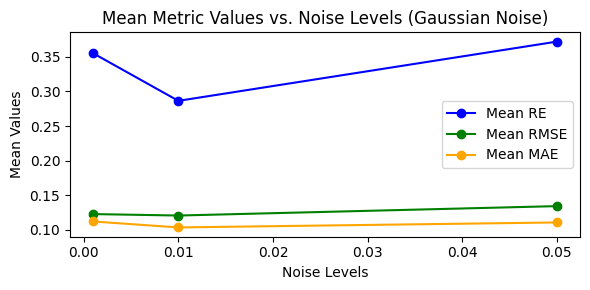

In [ ]:
import matplotlib.pyplot as plt

mean_re_values = [0.3551,0.2864,0.3720]
mean_rmse_values = [0.1227,0.1206,0.1342]
mean_mae_values = [0.1120,0.1034,0.1106]

noise_levels = [0.001, 0.01, 0.05]

plt.figure(figsize=(6,3))

plt.plot(noise_levels, mean_re_values, marker='o', label='Mean RE', color='blue')

plt.plot(noise_levels, mean_rmse_values, marker='o', label='Mean RMSE', color='green')

plt.plot(noise_levels, mean_mae_values, marker='o', label='Mean MAE', color='orange')

plt.xlabel('Noise Levels')
plt.ylabel('Mean Values')
plt.title('Mean Metric Values vs. Noise Levels (Gaussian Noise)')
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()
